In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras import losses, metrics
from tensorflow.keras import optimizers

2023-04-23 12:14:09.906078: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import time
import sys
sys.path.insert(0,'../..')
import gp2
from gp2 import Runner

2023-04-23 12:14:11.667677: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-23 12:14:12.031317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-23 12:14:12.037156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-23 12:14:12.037194: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-23 12:14:12.040840: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-23 

In [4]:
help(gp2.KUNet2D)

Help on class KUNet2D in module gp2.gp2.k_unet2d:

class KUNet2D(gp2.gp2.base_keras_segmentation_classifier.BaseKerasSegmentationClassifier)
 |  KUNet2D(input_size=(512, 512, 1), filter_num=None, n_labels=1, stack_num_down=3, stack_num_up=3, activation='ReLU', output_activation='Sigmoid', batch_norm=True, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet', optimizer=None, loss=None, metric=None, verbose=False, workingdir='/tmp')
 |  
 |  KU-Net 2D model.
 |  
 |  Method resolution order:
 |      KUNet2D
 |      gp2.gp2.base_keras_segmentation_classifier.BaseKerasSegmentationClassifier
 |      gp2.gp2.classifier.Classifier
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size=(512, 512, 1), filter_num=None, n_labels=1, stack_num_down=3, stack_num_up=3, activation='ReLU', output_activation='Sigmoid', batch_norm=True, pool=True, unpool=True, backbone=None, weights='imagenet', freeze_backb

In [5]:
R = Runner(verbose=True,
           classifier='kunet2d',
           filter_num=[32, 64, 128, 256, 512, 1024],
           stack_num_down=3,
           stack_num_up=3,
           activation='ReLU',
           output_activation='Sigmoid',
           batch_norm=True,
           pool=True,
           unpool=True,
           weights='imagenet',
           optimizer=None, # default is optimizers.Adam(learning_rate=1e-3)
           loss=None, # default is losses.binary_crossentropy
           metric=None # default is Util.dice_coef           
          )

2023-04-23 12:14:26.784952: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 12:14:27.006120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-23 12:14:27.008537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-23 12:14:27.032222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

*** GP2  KUNet2D ***
Working directory: /tmp/tmp2f0t11yjGP2
Verbose mode active!
{'verbose': True, 'workingdir': '/tmp/tmp2f0t11yjGP2', 'input_size': (512, 512, 1), 'filter_num': [32, 64, 128, 256, 512, 1024], 'n_labels': 1, 'stack_num_down': 3, 'stack_num_up': 3, 'activation': 'ReLU', 'output_activation': 'Sigmoid', 'batch_norm': True, 'pool': True, 'unpool': True, 'backbone': None, 'weights': 'imagenet', 'freeze_backbone': True, 'freeze_batch_norm': True, 'name': 'unet', 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f7a2958b760>, 'loss': <function binary_crossentropy at 0x7f7a2981ac10>, 'metric': [<function Util.dice_coef at 0x7f7a2959eb80>], 'model': <tensorflow.python.keras.engine.functional.Functional object at 0x7f79c5d42cd0>}
Model summary:
Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                  

In [6]:
# load our larger toy dataset (10k images and masks)
images = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/images.npy')
masks = np.load('/hpcstor6/scratch01/r/ryan.zurrin001/GP2TOYEXAMPLE_LARGE/masks.npy')

In [7]:
images = images[:5000]
masks = masks[:5000]

In [8]:
images.shape

(5000, 512, 512, 1)

In [9]:
masks.shape

(5000, 512, 512, 1)

In [10]:
weights = {
    'A': 0.5,
    'A_train': 0.1,
    'A_val': 0.3,
    'A_test': 0.6,
    'B': 0.3,
    'B_train': 0.7,
    'B_val': 0.1,
    'B_test': 0.2,
    'Z': 0.2
}

In [17]:

R.run(images=images, masks=masks, weights=weights, runs=5)

Weights OK!
******
Loop 0
Epoch 1/100


2023-04-23 12:17:48.906070: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.00GiB (rounded to 1073741824)requested by op unet_model/unet_up4_conv_after_concat_2_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-23 12:17:48.906149: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-04-23 12:17:48.906167: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 217, Chunks in use: 217. 54.2KiB allocated for chunks. 54.2KiB in use in bin. 27.2KiB client-requested in use in bin.
2023-04-23 12:17:48.906179: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 70, Chunks in use: 70. 35.0KiB allocated for chunks. 35.0KiB in use in bin. 35.0KiB client-req

ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,512,512] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node unet_model/unet_up4_conv_after_concat_2_bn/FusedBatchNormV3 (defined at home/ryan.zurrin001/Projects/CS410-Omama/_EXPERIMENTS/GP2/../../gp2/gp2/base_keras_segmentation_classifier.py:47) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_10533]

Function call stack:
train_function


In [ ]:
R.classifier_scores

In [ ]:
R.discriminator_scores

In [ ]:
R.plot()

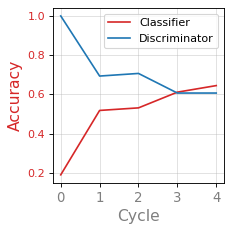

In [18]:
R.plot()

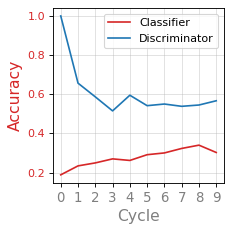

In [18]:
R.plot()

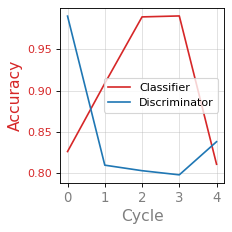

In [17]:
R.plot()